In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("banudeep/nthuddd2")

print("Path to dataset files:", path)

c:\Users\luizc\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 2.81G/2.81G [02:04<00:00, 24.3MB/s]

Extracting files...


Path to dataset files: C:\Users\luizc\.cache\kagglehub\datasets\banudeep\nthuddd2\versions\1


In [1]:
import tensorflow as tf
import os
import pathlib
import numpy as np
from sklearn.model_selection import train_test_split

IMAGE_SIZE = (224, 224)
SEQ_LENGTH = 10   # Tamanho da sequência para a LSTM
BATCH_SIZE = 4    # Batch pequeno para economizar memória (4 vídeos de 10 frames = 40 imgs)
AUTOTUNE = tf.data.AUTOTUNE


DATASET_DIR = r"C:\Users\luizc\.cache\kagglehub\datasets\banudeep\nthuddd2\versions\1"

print(f"Processando dataset em: {DATASET_DIR}")

def find_and_group_sequences(root_dir):
    all_seqs = []
    all_lbls = []
    for current_folder, dirs, files in os.walk(root_dir):

        images = [f for f in files if f.lower().endswith('.jpg')]
        
        if len(images) >= SEQ_LENGTH:
            images = sorted(images) 
            folder_lower = current_folder.lower()
            label = None
            
            if "notdrowsy" in folder_lower:
                label = 0 # Alerta
            elif "drowsy" in folder_lower:
                label = 1 # Fadiga
            
            if label is not None:
                full_paths = [os.path.join(current_folder, img) for img in images]
                
                current_folder_seqs = []
                for i in range(0, len(full_paths) - SEQ_LENGTH + 1, SEQ_LENGTH):
                    window = full_paths[i : i + SEQ_LENGTH]
                    if len(window) == SEQ_LENGTH:
                        current_folder_seqs.append(window)
                        all_lbls.append(label)
                
                all_seqs.extend(current_folder_seqs)

    return all_seqs, all_lbls


all_sequences, all_labels = find_and_group_sequences(DATASET_DIR)

print(f"TOTAL ENCONTRADO:")
print(f"Sequências Totais (Vídeos de 10 frames): {len(all_sequences)}")
print(f"Fadiga (Label 1): {all_labels.count(1)}")
print(f"Alerta (Label 0): {all_labels.count(0)}")


if len(all_sequences) == 0:
    raise ValueError("Nenhuma sequência encontrada! Verifique o caminho.")

train_paths, val_paths, train_labels, val_labels = train_test_split(
    all_sequences, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

def load_single_image(path):
    file_content = tf.io.read_file(path)
    image = tf.io.decode_jpeg(file_content, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.keras.applications.resnet_v2.preprocess_input(image)
    return image

def load_video_sequence(sequence_paths, label):
    video = tf.map_fn(load_single_image, sequence_paths, dtype=tf.float32)
    return video, label


#erro de memoria remover a linha cache

train_dataset = (
    train_ds
    .map(load_video_sequence, num_parallel_calls=AUTOTUNE)
    #.cache() 
    .shuffle(500)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_dataset = (
    val_ds
    .map(load_video_sequence, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    #.cache() 
    .prefetch(AUTOTUNE)
)

print("Dataset NTHU-DDD carregado")

Processando dataset em: C:\Users\luizc\.cache\kagglehub\datasets\banudeep\nthuddd2\versions\1
TOTAL ENCONTRADO:
Sequências Totais (Vídeos de 10 frames): 6652
Fadiga (Label 1): 3603
Alerta (Label 0): 3049
Instructions for updating:
Use fn_output_signature instead
Dataset NTHU-DDD carregado


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ==============================================================================
# 1. CONFIGURAÇÕES DA ARQUITETURA
# ==============================================================================
IMAGE_SIZE = 224
CHANNELS = 3
SEQ_LENGTH = 10  # Deve ser igual ao usado na preparação dos dados (10 frames)
NUM_CLASSES = 1  # Binário (Fadiga ou Alerta)

print("Construindo o Modelo Híbrido CNN-LSTM...")

# ==============================================================================
# 2. CONSTRUÇÃO DO EXTRATOR DE CARACTERÍSTICAS (A "VISÃO")
# ==============================================================================
# Vamos usar a ResNet50V2 como base, pois ela é poderosa para detalhes.
# Nota: Ela processa UMA imagem por vez. O TimeDistributed vai lidar com o vídeo depois.

def build_cnn_base():
    base_model = tf.keras.applications.ResNet50V2(
        include_top=False, 
        weights='imagenet', 
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    )
    # Congelamos a base inicialmente para não destruir os pesos treinados
    base_model.trainable = False 
    
    # Criamos o bloco CNN completo
    cnn_input = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    x = base_model(cnn_input)
    x = layers.GlobalAveragePooling2D()(x) # Transforma (7,7,2048) em (2048,)
    
    return models.Model(inputs=cnn_input, outputs=x, name="ResNet_Feature_Extractor")

cnn_extractor = build_cnn_base()

# ==============================================================================
# 3. CONSTRUÇÃO DO MODELO TEMPORAL (A "MEMÓRIA")
# ==============================================================================

# Entrada: Um "vídeo" com 10 frames
video_input = layers.Input(shape=(SEQ_LENGTH, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# CAMADA MÁGICA: TimeDistributed
# Ela aplica a "cnn_extractor" em CADA UM dos 10 frames individualmente.
# Entrada: (Batch, 10, 224, 224, 3) -> Saída: (Batch, 10, 2048)
encoded_frames = layers.TimeDistributed(cnn_extractor)(video_input)

# LSTM
# Agora temos uma sequência de 10 vetores de características.
# A LSTM lê essa sequência e aprende o padrão temporal (ex: olhos fechando devagar)
x = layers.LSTM(64, return_sequences=False)(encoded_frames) 
# return_sequences=False: Queremos apenas UMA decisão final após ver os 10 frames.

# Regularização para evitar Overfitting
x = layers.Dropout(0.5)(x)

# Classificação Final
outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)

# ==============================================================================
# 4. MONTAGEM E COMPILAÇÃO
# ==============================================================================

model_hibrido = models.Model(inputs=video_input, outputs=outputs, name="ResNet_LSTM_Network")

# Usamos um Learning Rate baixo (1e-4) porque a arquitetura é complexa
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_hibrido.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Recall(name='recall')]
)

print("✅ Modelo Construído!")
model_hibrido.summary()

Construindo o Modelo Híbrido CNN-LSTM...
✅ Modelo Construído!


Model: "ResNet_LSTM_Network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 2048)       │    23,564,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,105,793 (91.96 MB)

 Trainable params: 540,993 (2.06 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [ ]:
print("Iniciando treinamento...")

history_hibrido = model_hibrido.fit(
    train_dataset,          
    epochs=10,              
    validation_data=validation_dataset
)

Iniciando treinamento...
Epoch 1/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 982s 719ms/step - accuracy: 0.7827 - loss: 0.4520 - recall: 0.8338 - val_accuracy: 0.8595 - val_loss: 0.3222 - val_recall: 0.9778
Epoch 2/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 966s 725ms/step - accuracy: 0.8837 - loss: 0.2702 - recall: 0.9094 - val_accuracy: 0.9053 - val_loss: 0.2302 - val_recall: 0.9736
Epoch 3/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 995s 746ms/step - accuracy: 0.9034 - loss: 0.2241 - recall: 0.9212 - val_accuracy: 0.8971 - val_loss: 0.2383 - val_recall: 0.9612
Epoch 4/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 1042s 782ms/step - accuracy: 0.9258 - loss: 0.1852 - recall: 0.9389 - val_accuracy: 0.9271 - val_loss: 0.1800 - val_recall: 0.9806
Epoch 5/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 909s 682ms/step - accuracy: 0.9284 - loss: 0.1793 - recall: 0.9452 - val_accuracy: 0.9309 - val_loss: 0.1523 - val_recall: 0.9639
Epoch 6/10
1331/1331 ━━━━━━━━━━━━━━━━━━━━ 907s 680ms/step - accuracy: 0.9354 - loss: 0.1620 - recall: 0.9455 - val

In [5]:
import os
import pickle
import tensorflow as tf

MODELS_DIR = "saved_models"
HISTORIES_DIR = "historicos"
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(HISTORIES_DIR, exist_ok=True)

model_filename = 'modelo_hibrido_cnn_lstm.keras'
history_filename = 'history_hibrido_cnn_lstm.pkl'

model_path = os.path.join(MODELS_DIR, model_filename)

model_hibrido.save(model_path) 

history_path = os.path.join(HISTORIES_DIR, history_filename)
with open(history_path, 'wb') as file:
    pickle.dump(history_hibrido.history, file)

loaded_model = tf.keras.models.load_model(model_path)
target_output = None

for layer in loaded_model.layers:
    if isinstance(layer, tf.keras.layers.LSTM):
        print(f"Camada LSTM encontrada: '{layer.name}'")
        target_output = layer.output
        break

if target_output is None:
    print("Aviso: Camada LSTM não encontrada pelo tipo. Pegando a saída da penúltima camada.")
    target_output = loaded_model.layers[-2].output

feature_extractor = tf.keras.Model(
    inputs=loaded_model.input,
    outputs=target_output,
    name="Extrator_Temporal_LSTM"
)

feature_extractor.summary()

Camada LSTM encontrada: 'lstm'


Model: "Extrator_Temporal_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10, 224, 224,   │             0 │
│                                 │ 3)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 2048)       │    23,564,800 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │       540,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,105,728 (91.96 MB)

 Trainable params: 540,928 (2.06 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

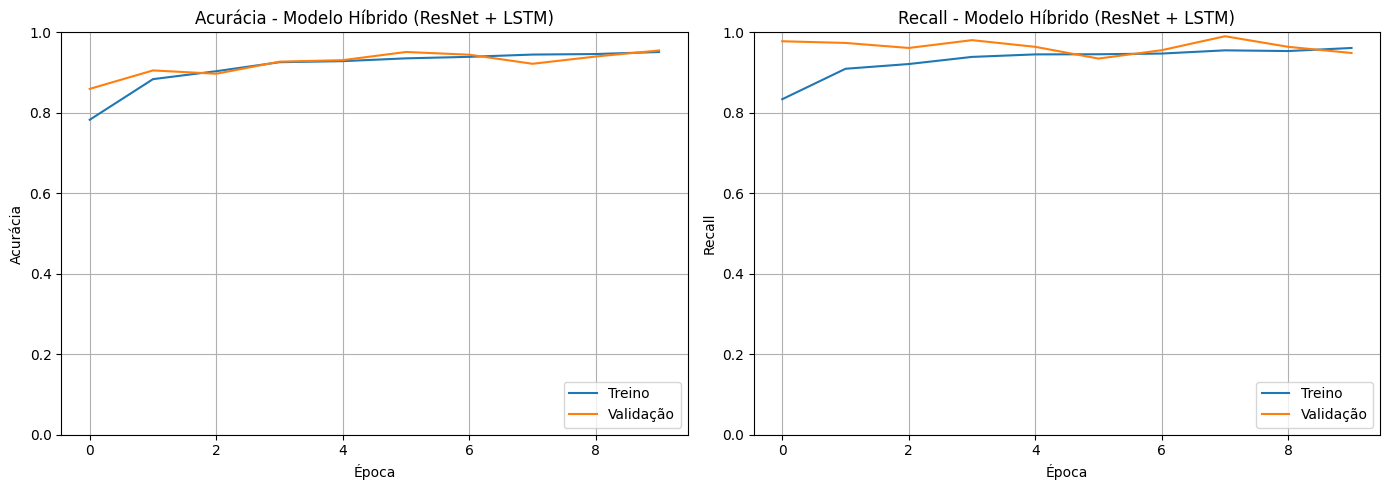


--- Métricas Finais no Dataset de Validação ---
333/333 - 366s - 1s/step - accuracy: 0.9549 - loss: 0.1158 - recall: 0.9487

Loss (Erro): 0.1158
Acurácia Final: 95.49%
Recall Final: 94.87%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 5))
#gráfico 1 - acurácia
plt.subplot(1, 2, 1)
plt.title("Acurácia - Modelo Híbrido (ResNet + LSTM)")
plt.plot(history_hibrido.history['accuracy'], label='Treino')
plt.plot(history_hibrido.history['val_accuracy'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim([0, 1]) # Ajustei para 0 a 1 para ver o contexto todo
plt.legend(loc='lower right')
plt.grid(True)

#gráfico 2 - recall
plt.subplot(1, 2, 2)
plt.title("Recall - Modelo Híbrido (ResNet + LSTM)")
plt.plot(history_hibrido.history['recall'], label='Treino')
plt.plot(history_hibrido.history['val_recall'], label='Validação')
plt.xlabel('Época')
plt.ylabel('Recall')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()
print("\n--- Métricas Finais no Dataset de Validação ---")

# O evaluate retorna 3 valores porque foi compilado com: loss, accuracy, recall
val_loss, val_acc, val_recall = model_hibrido.evaluate(validation_dataset, verbose=2)

print(f"\nLoss (Erro): {val_loss:.4f}")
print(f"Acurácia Final: {val_acc * 100:.2f}%")
print(f"Recall Final: {val_recall * 100:.2f}%")